# Genetic Algorithm Assignment - 2D Pixel Game Map Generator.

# The Problem
# Overview of the problem

---

The project tackles procedural map generation for 2D pixel games, particularly those inspired by the Metroidvania genre.

These games often feature interconnected rooms separated by walls and doors, promising unique playthrough experiences.

However, many such games rely on pre-designed rooms and algorithmic placement, limiting true variability.

This project explores the potential of generating entirely novel 2D maps with randomly sized rooms, constrained by a user-specified overall map width and height.

This dynamic approach aims to enhance replayability by offering genuinely unique level layouts for each playthrough, moving beyond the limitations of pre-fabricated room selection.

---



## Discussion of the suitablity of Genetic Algorithms

---

Genetic Algorithms (GAs) are well-suited for this project due to their inherent ability to explore a large and complex solution space, mimicking the organic process of evolution.

The goal is to create randomly generated rooms that form a cohesive and playable map. GAs excel at iteratively refining solutions, offering a dynamic approach to discovering optimal or acceptable room configurations within the given map dimensions.

This adaptability aligns perfectly with the desire for a unique gameplay experience. However, the success of a GA hinges on careful design choices, especially concerning chromosome representation, fitness function definition, and balancing exploration (searching new possibilities) with exploitation (refining promising solutions).

The effectiveness of the GA in fully resolving the problem will depend on addressing these challenges, which will be a central focus of the project.

---



## Complexity of the problem

---
This project's complexity stems from several core challenges inherent in procedural level generation.

First, defining criteria for "valid" rooms is crucial, requiring careful consideration of size constraints (minimum and maximum dimensions), aspect ratios, and avoiding overly complex or impractical shapes.

Second, ensuring room connectivity to create a navigable map necessitates strategically placing doors and evaluating the overall layout's connectivity, potentially involving pathfinding and graph analysis algorithms.

Finally, designing effective genetic operators (mutation and crossover) is critical for guiding the GA's search. These operators must modify the map representation while preserving valid room structures and exploring new configurations, a task made more challenging by the tile-based representation.

Addressing these interconnected challenges is essential for creating a functional and usable map generator.

Success will be measured by the validity of the generated maps, the GA's efficiency in finding good solutions, and the system's ability to produce diverse level layouts.

---



# The problem and the cost function   **(~20%)**

# Problem, Cost Function, and Associated Challenges

This project's core challenge lies in defining and evaluating the validity of generated rooms within a tile-based map. Several approaches were explored to develop a robust cost function for this purpose.

The GitHub Repo for this project:
https://github.com/adam-omah/AI-Class under the file GA_Map_Generator.ipynb


### Initial Scoring attempt
The initial attempt involved a depth-first scoring approach, traversing and validating wall tiles sequentially.

However, inconsistencies arose in mapping scores due to the relative nature of coordinate tracking during the traversal, making it difficult to maintain accurate scores for individual tiles.

The relation of the back tracing was based on relative position to the tile being checked, as such it was taking a long time, and it was not able to correctly relate this information to the tile map itself.

While ultimately flawed, aspects of this depth-first approach informed the final cost function's design.

### Simplified Scoring approach
A subsequent, simpler approach focused on individual tile validity, assigning base scores based on neighboring tiles and bonus points for door connections.

 This method, while producing reasonable results, failed to adequately validate walls connected to doors, leading to incomplete or illogical room structures.

### Wall Validation via Depth-First Searching
To address this, a depth-first search validation was implemented to check if a wall connected back to a door.

This, however, proved insufficient as it didn't differentiate between doors, resulting in valid walls being associated with incorrect doors and leading to undesirable configurations.

Such as the image below shows the valid walls looping back towards the door it starts at:

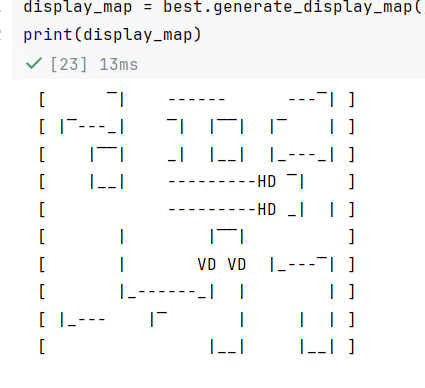


### Final Door Count Validation.
Finally, a door count validation using a modified depth-first search was adopted to resolve the issues of the previous methods.

This new validation checks for doors connected to a wall segment, adding each distinct door to a count and traversing in the opposite direction from the door to explore further connections.

The validation logic for doors was also modified to handle the issue of "Partner Doors" that represent the same passage between rooms but occupy adjacent tiles.

Without accounting for door partners, the algorithm could incorrectly identify two doors when, in fact, it had only found one doorway. This would lead to inflated scores for walls within a single room and the creation of undesirable "tunnels" rather than genuine connections between rooms.

The algorithm now explicitly checks for and excludes door partners during the search process. The search returns a value of 1 if a wall connects to one distinct door and 2 if it connects to two distinct doors (excluding door partners).

This count is used to apply a bonus to valid wall tiles' scores, with the multiplication factors for these bonuses defined in the parameters section.

This refinement, along with increasing the two-door connection bonus from 4x to 20x the base score, significantly improved the generation of enclosed rooms and ultimately produced more viable and playable level layouts.

---

In [2]:
# Parameters
import numpy as np
from copy import deepcopy
import random


# Tile wall index values
TILE_WALL_VERTICAL = 0
TILE_WALL_HORIZONTAL = 1
TILE_WALL_CORNER_BOTTOM_LEFT = 2
TILE_WALL_CORNER_BOTTOM_RIGHT = 3
TILE_WALL_CORNER_TOP_RIGHT = 4
TILE_WALL_CORNER_TOP_LEFT = 5
TILE_FLOOR = 6
TILE_DOOR_HORIZONTAL = 7
TILE_DOOR_VERTICAL = 8
TILE_INVALID = -1



In [3]:
# Door generator:
def generate_door_positions(width,height,num_rooms):
        """
        Generate immutable door positions for the map.
        Doors are restricted to being within N-3 x N-3 to ensure they are further inside the map.
        Vertical doors are accompanied by an additional door at x-1,
        Horizontal doors are accompanied by an additional door at y-1.
        """
        positions = []
        for _ in range(num_rooms - 1):  # Generate `num_rooms - 1` doors
            while True:
                # Generate door positions further inside the map
                x = random.randint(2, width - 3)
                y = random.randint(2, height - 3)
                orientation = random.choice([TILE_DOOR_HORIZONTAL, TILE_DOOR_VERTICAL])  # Random door type

                if orientation == TILE_DOOR_VERTICAL:
                    # Ensure space for the companion door at (x-1, y)
                    if x - 1 >= 1:  # Check bounds
                        positions.append((x, y, TILE_DOOR_VERTICAL))  # Main door
                        positions.append((x - 1, y, TILE_DOOR_VERTICAL))  # Companion door
                        break
                elif orientation == TILE_DOOR_HORIZONTAL:
                    # Ensure space for the companion door at (x, y-1)
                    if y - 1 >= 1:  # Check bounds
                        positions.append((x, y, TILE_DOOR_HORIZONTAL))  # Main door
                        positions.append((x, y - 1, TILE_DOOR_HORIZONTAL))  # Companion door
                        break

        return positions

In [4]:
#  Problem & Fitness scoring
class LevelGenerationProblem:
    def __init__(self, params):
        self.width = params.map_width  # Map width (N)
        self.height = params.map_height  # Map height (N)
        self.parameters = params
        self.num_rooms = params.num_rooms  # Number of rooms
        self.door_positions = params.door_positions


    def calculate_fitness(self, chromosome):
        """
        Fitness evaluation for a map, returning fitness and a score map.
        """
        map_with_doors = chromosome
        # Initialize fitness and create a score map same shape as the map
        fitness_score = 0
        score_map = np.zeros((self.height, self.width), dtype=int)

        # Iterate through every tile on the map
        for y in range(self.height):
            for x in range(self.width):
                tile_type = map_with_doors[y, x]

                # Skip non-evaluable tiles
                if tile_type not in [
                    TILE_WALL_HORIZONTAL,
                    TILE_WALL_VERTICAL,
                    TILE_DOOR_HORIZONTAL,
                    TILE_DOOR_VERTICAL,
                    TILE_WALL_CORNER_BOTTOM_LEFT,
                    TILE_WALL_CORNER_BOTTOM_RIGHT,
                    TILE_WALL_CORNER_TOP_RIGHT,
                    TILE_WALL_CORNER_TOP_LEFT,
                ]:
                    continue

                # Evaluate the single tile at (x, y)
                is_valid, tile_score = self.validate_tile(map_with_doors, x, y)

                # Aggregate the tile's contribution to the total fitness
                fitness_score += tile_score

                # Update the score map for the current tile
                score_map[y, x] = tile_score

        valid_wall_map = self.validate_connected_tiles(score_map, map_with_doors)
        #based on valid_wall_map, apply bonuses to scoring.
        updated_score_map = self.bonus_score_for_validated_map(score_map, valid_wall_map)

        # Return total fitness and the aligned score map as a 2D numpy array
        return fitness_score, updated_score_map, valid_wall_map

    def bonus_score_for_validated_map(self, score_map, valid_wall_map):
        # Iterate through every position in the map
        for y in range(score_map.shape[0]):  # Loop over rows
            for x in range(score_map.shape[1]):  # Loop over columns
                # If the tile is valid (indicated by 1 in valid_wall_map), double the score
                if valid_wall_map[y, x] == 1:
                    score_map[y, x] *= self.parameters.bonus_for_one_door
                elif valid_wall_map[y, x] == 2:
                    score_map[y, x] *= self.parameters.bonus_for_two_doors

        # Return the modified score_map
        return score_map


    def validate_tile(self, tile_map, x, y):
        """
        Evaluate a single tile in the given map.
        Returns:
            is_valid (bool): Whether the tile contributes validly to the enclosure.
            tile_score (int): The score of the tile.
        """
        # Ensure the tile lies within valid map bounds
        if not (0 <= x < self.width and 0 <= y < self.height):
            return False, -1, {(x, y): -1}  # Invalid position outside map bounds

        tile = tile_map[y, x]  # Access the tile
        is_valid = True  # By default, assume the tile is valid
        tile_score = 0  # Tile's contribution to fitness

        # Evaluate the tile's score based on its type
        if tile in [TILE_WALL_HORIZONTAL, TILE_DOOR_HORIZONTAL]:
            is_valid, tile_score = self.validate_horizontal_tile(tile_map, x, y)
        elif tile in [TILE_WALL_VERTICAL, TILE_DOOR_VERTICAL]:
            is_valid, tile_score = self.validate_vertical_tile(tile_map, x, y)
        elif tile == TILE_WALL_CORNER_BOTTOM_LEFT:
            is_valid, tile_score = self.validate_bottom_left_corner(tile_map, x, y)
        elif tile == TILE_WALL_CORNER_BOTTOM_RIGHT:
            is_valid, tile_score = self.validate_bottom_right_corner(tile_map, x, y)
        elif tile == TILE_WALL_CORNER_TOP_RIGHT:
            is_valid, tile_score = self.validate_top_right_corner(tile_map, x, y)
        elif tile == TILE_WALL_CORNER_TOP_LEFT:
            is_valid, tile_score = self.validate_top_left_corner(tile_map, x, y)
        elif tile == TILE_FLOOR:  # Assign flat score for floor tiles
            is_valid, tile_score = True, 1
        else:  # Invalid or unknown tile types
            is_valid, tile_score = False, -1

        # Return the results for this single tile
        return is_valid, tile_score



    def validate_horizontal_tile(self, tile_map, x, y):
        """
        Validate a horizontal wall or door tile by considering its left, right,
        and whether its partner door is above or below.
        """
        left = tile_map[y, x - 1] if x - 1 >= 0 else TILE_INVALID
        right = tile_map[y, x + 1] if x + 1 < self.width else TILE_INVALID
        above = tile_map[y - 1, x] if y - 1 >= 0 else TILE_INVALID
        below = tile_map[y + 1, x] if y + 1 < self.height else TILE_INVALID

        # Determine if the door has a partner above or below
        has_partner_above = above == TILE_DOOR_HORIZONTAL
        has_partner_below = below == TILE_DOOR_HORIZONTAL

        # Base validation for left and right
        valid_left = left in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_LEFT, TILE_WALL_CORNER_BOTTOM_LEFT,
                              TILE_DOOR_HORIZONTAL]
        valid_right = right in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_RIGHT, TILE_WALL_CORNER_BOTTOM_RIGHT,
                                TILE_DOOR_HORIZONTAL]

        # Adjust validation based on partner position
        if has_partner_above:
            # Partner is above: Exclude bottom corners
            valid_left = valid_left and left not in [TILE_WALL_CORNER_BOTTOM_LEFT]
            valid_right = valid_right and right not in [TILE_WALL_CORNER_BOTTOM_RIGHT]
        elif has_partner_below:
            # Partner is below: Exclude top corners
            valid_left = valid_left and left not in [TILE_WALL_CORNER_TOP_LEFT]
            valid_right = valid_right and right not in [TILE_WALL_CORNER_TOP_RIGHT]

        is_valid = valid_left and valid_right

        # Adjust scoring
        base_score = 10
        door_bonus = 50 if tile_map[y, x] == TILE_DOOR_HORIZONTAL else 0
        neighbor_door_bonus = 20 if left == TILE_DOOR_HORIZONTAL or right == TILE_DOOR_HORIZONTAL else 0

        score = base_score + door_bonus + neighbor_door_bonus
        score = score if is_valid else -3

        return is_valid, score


    def validate_vertical_tile(self, tile_map, x, y):
        """
        Validate a vertical wall or door tile by checking its top, bottom, left, and right neighbors.
        """
        above = tile_map[y - 1, x] if y - 1 >= 0 else TILE_INVALID
        below = tile_map[y + 1, x] if y + 1 < self.height else TILE_INVALID
        left = tile_map[y, x - 1] if x - 1 >= 0 else TILE_INVALID
        right = tile_map[y, x + 1] if x + 1 < self.width else TILE_INVALID

        # Determine if the door has a partner to the left or right
        has_partner_left = left == TILE_DOOR_VERTICAL
        has_partner_right = right == TILE_DOOR_VERTICAL

        # Base validation for above and below
        valid_above = above in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_TOP_LEFT, TILE_WALL_CORNER_TOP_RIGHT,
                                TILE_DOOR_VERTICAL]
        valid_below = below in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_BOTTOM_LEFT, TILE_WALL_CORNER_BOTTOM_RIGHT,
                                TILE_DOOR_VERTICAL]

        # Adjust validation based on partner position
        if has_partner_right:
            # Partner is to the right: Disallow top-left and bottom-left corners
            valid_above = valid_above and above not in [TILE_WALL_CORNER_TOP_LEFT]
            valid_below = valid_below and below not in [TILE_WALL_CORNER_BOTTOM_LEFT]
        elif has_partner_left:
            # Partner is to the left: Disallow top-right and bottom-right corners
            valid_above = valid_above and above not in [TILE_WALL_CORNER_TOP_RIGHT]
            valid_below = valid_below and below not in [TILE_WALL_CORNER_BOTTOM_RIGHT]

        is_valid = valid_above and valid_below

        # Adjust scoring
        base_score = 10
        door_bonus = 50 if tile_map[y, x] == TILE_DOOR_VERTICAL else 0
        neighbor_door_bonus = 20 if above == TILE_DOOR_VERTICAL or below == TILE_DOOR_VERTICAL else 0

        score = base_score + door_bonus + neighbor_door_bonus
        score = score if is_valid else -3

        return is_valid, score



    def validate_bottom_left_corner(self, tile_map, x, y):
        """Validate a bottom-left corner based on its neighbors."""
        above = tile_map[y - 1, x] if y - 1 >= 0 else TILE_INVALID
        right = tile_map[y, x + 1] if x + 1 < self.width else TILE_INVALID

        valid_above = above in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_TOP_LEFT, TILE_DOOR_VERTICAL]
        valid_right = right in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_BOTTOM_RIGHT, TILE_DOOR_HORIZONTAL]

        is_valid = valid_above and valid_right
        base_score = 10
        # Add bonuses for neighboring doors
        neighbor_door_bonus = 20 if above == TILE_DOOR_VERTICAL else 0
        neighbor_door_bonus += 20 if right == TILE_DOOR_HORIZONTAL else 0

        # Calculate final score
        score = base_score + neighbor_door_bonus
        score = score if is_valid else -3

        return is_valid, score

    def validate_bottom_right_corner(self, tile_map, x, y):
        """Validate a bottom-right corner based on its neighbors."""
        above = tile_map[y - 1, x] if y - 1 >= 0 else TILE_INVALID
        left = tile_map[y, x - 1] if x - 1 >= 0 else TILE_INVALID

        valid_above = above in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_TOP_RIGHT, TILE_DOOR_VERTICAL]
        valid_left = left in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_BOTTOM_LEFT, TILE_DOOR_HORIZONTAL]

        is_valid = valid_above and valid_left
        base_score = 10
        # Add bonuses for neighboring doors
        neighbor_door_bonus = 20 if above == TILE_DOOR_VERTICAL else 0
        neighbor_door_bonus += 20 if left == TILE_DOOR_HORIZONTAL else 0

        # Calculate final score
        score = base_score + neighbor_door_bonus
        score = score if is_valid else -3

        return is_valid, score

    def validate_top_right_corner(self, tile_map, x, y):
        """Validate a top-right corner based on its neighbors."""
        below = tile_map[y + 1, x] if y + 1 < self.height else TILE_INVALID
        left = tile_map[y, x - 1] if x - 1 >= 0 else TILE_INVALID

        valid_below = below in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_BOTTOM_RIGHT, TILE_DOOR_VERTICAL]
        valid_left = left in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_LEFT, TILE_DOOR_HORIZONTAL]

        is_valid = valid_below and valid_left
        base_score = 10
        # Add bonuses for neighboring doors
        neighbor_door_bonus = 20 if below == TILE_DOOR_VERTICAL else 0
        neighbor_door_bonus += 20 if left == TILE_DOOR_HORIZONTAL else 0

        # Calculate final score
        score = base_score + neighbor_door_bonus
        score = score if is_valid else -3

        return is_valid, score

    def validate_top_left_corner(self, tile_map, x, y):
        """Validate a top-left corner based on its neighbors."""
        below = tile_map[y + 1, x] if y + 1 < self.height else TILE_INVALID
        right = tile_map[y, x + 1] if x + 1 < self.width else TILE_INVALID

        valid_below = below in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_BOTTOM_LEFT, TILE_DOOR_VERTICAL]
        valid_right = right in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_RIGHT, TILE_DOOR_HORIZONTAL]

        is_valid = valid_below and valid_right
        base_score = 10
        # Add bonuses for neighboring doors
        neighbor_door_bonus = 20 if below == TILE_DOOR_VERTICAL else 0
        neighbor_door_bonus += 20 if right == TILE_DOOR_HORIZONTAL else 0

        # Calculate final score
        score = base_score + neighbor_door_bonus
        score = score if is_valid else -3

        return is_valid, score

    def validate_connected_tiles(self, score_map, tile_map):
        """
        Validates connected tiles, ensuring walls connect correctly to doors.

        Inputs:
            score_map: Fitness scoring map for penalties/rewards.
            tile_map: Map containing the specific tile type at each (x, y).

        Outputs:
            valid_wall_map: Map showing which tiles are valid, penalized, or rewarded.
        """
        valid_wall_map = np.zeros((self.height, self.width), dtype=int)
        visited = set()  # Track visited tiles to avoid redundant checks

        def is_valid_tile_neighbor(tile_pos, neighbor_pos, tile_map):
            """
            Validates whether `tile_pos` and `neighbor_pos` connect correctly, considering
            both the tile types in `tile_map` and the relative position of the neighbor.
            """
            ty, tx = tile_pos
            ny, nx = neighbor_pos

            # Ensure neighbors are within bounds
            if not (0 <= nx < self.width and 0 <= ny < self.height):
                return False  # Out-of-bounds tiles are invalid neighbors

            # Tile types
            tile_type = tile_map[ty, tx]
            neighbor_type = tile_map[ny, nx]

            # Determine the relative position of the neighbor
            relative_position = (ny - ty, nx - tx)  # (row_diff, col_diff)

            # Check rules for connecting based on the current tile type
            if tile_type == TILE_WALL_VERTICAL:
                # Neighbors above or below
                if relative_position == (-1, 0):  # Above
                    return neighbor_type in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_TOP_LEFT, TILE_WALL_CORNER_TOP_RIGHT,
                                             TILE_DOOR_VERTICAL]
                elif relative_position == (1, 0):  # Below
                    return neighbor_type in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_BOTTOM_LEFT, TILE_WALL_CORNER_BOTTOM_RIGHT,
                                             TILE_DOOR_VERTICAL]

            elif tile_type == TILE_WALL_HORIZONTAL:
                # Neighbors to the left or right
                if relative_position == (0, -1):  # Left
                    return neighbor_type in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_LEFT, TILE_WALL_CORNER_BOTTOM_LEFT,
                                             TILE_DOOR_HORIZONTAL]
                elif relative_position == (0, 1):  # Right
                    return neighbor_type in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_RIGHT, TILE_WALL_CORNER_BOTTOM_RIGHT,
                                             TILE_DOOR_HORIZONTAL]

            elif tile_type == TILE_WALL_CORNER_TOP_LEFT:
                # Valid neighbors for top-left corner
                if relative_position == (0, 1):  # Right
                    return neighbor_type in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_RIGHT, TILE_DOOR_HORIZONTAL]
                elif relative_position == (1, 0):  # Below
                    return neighbor_type in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_BOTTOM_LEFT, TILE_DOOR_VERTICAL]

            elif tile_type == TILE_WALL_CORNER_TOP_RIGHT:
                # Valid neighbors for top-right corner
                if relative_position == (0, -1):  # left
                    return neighbor_type in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_LEFT, TILE_DOOR_HORIZONTAL]
                elif relative_position == (1, 0):  # Below
                    return neighbor_type in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_BOTTOM_RIGHT, TILE_DOOR_VERTICAL]

            elif tile_type == TILE_WALL_CORNER_BOTTOM_LEFT:
                # Valid neighbors for bottom-left corner
                if relative_position == (0, 1):  # Right
                    return neighbor_type in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_BOTTOM_RIGHT, TILE_DOOR_HORIZONTAL]
                elif relative_position == (-1, 0):  # Above
                    return neighbor_type in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_TOP_LEFT, TILE_DOOR_VERTICAL]

            elif tile_type == TILE_WALL_CORNER_BOTTOM_RIGHT:
                # Valid neighbors for bottom-right corner
                if relative_position == (0, -1):  # Left
                    return neighbor_type in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_BOTTOM_LEFT, TILE_DOOR_HORIZONTAL]
                elif relative_position == (-1, 0):  # Above
                    return neighbor_type in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_TOP_RIGHT, TILE_DOOR_VERTICAL]

            elif tile_type == TILE_DOOR_VERTICAL:
                # Vertical doors can connect to vertical walls or corners above and below
                if relative_position == (-1, 0):  # Above
                    return neighbor_type in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_BOTTOM_LEFT, TILE_WALL_CORNER_BOTTOM_RIGHT]
                elif relative_position == (1, 0):  # Below
                    return neighbor_type in [TILE_WALL_VERTICAL, TILE_WALL_CORNER_TOP_LEFT, TILE_WALL_CORNER_TOP_RIGHT]

            elif tile_type == TILE_DOOR_HORIZONTAL:
                # Horizontal doors can connect to horizontal walls or corners left and right
                if relative_position == (0, -1):  # Left
                    return neighbor_type in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_RIGHT, TILE_WALL_CORNER_BOTTOM_RIGHT]
                elif relative_position == (0, 1):  # Right
                    return neighbor_type in [TILE_WALL_HORIZONTAL, TILE_WALL_CORNER_TOP_LEFT, TILE_WALL_CORNER_BOTTOM_LEFT]

            return False  # If no rules apply, the neighbor is invalid



        def is_connected_to_door(y, x, tile_map, visited, score_map, original_direction=None):
            """
            Checks if a tile is connected to doors using Depth-First Search (DFS).
            Returns a tuple of (door_count, list_of_door_positions).
            Door positions are returned as (y, x) coordinates.
            """
            if (
                    (y, x) in visited
                    or not (0 <= x < self.width and 0 <= y < self.height)
                    or score_map[y][x] == -3
            ):
                return 0, []  # Return count and empty list of positions

            visited.add((y, x))

            if tile_map[y][x] in [TILE_DOOR_HORIZONTAL, TILE_DOOR_VERTICAL]:
                return 1, [(y, x)]  # Return count=1 and this door's position

            door_count = 0
            door_positions = []  # Track positions of all connected doors
            current_tile_type = tile_map[y][x]
            neighbors = []

            # Neighbor logic remains the same
            if current_tile_type == TILE_WALL_VERTICAL:
                neighbors = [(y + 1, x), (y - 1, x)]
            elif current_tile_type == TILE_WALL_HORIZONTAL:
                neighbors = [(y, x + 1), (y, x - 1)]
            elif current_tile_type == TILE_WALL_CORNER_TOP_LEFT:
                neighbors = [(y, x + 1), (y + 1, x)]
            elif current_tile_type == TILE_WALL_CORNER_TOP_RIGHT:
                neighbors = [(y, x - 1), (y + 1, x)]
            elif current_tile_type == TILE_WALL_CORNER_BOTTOM_LEFT:
                neighbors = [(y, x + 1), (y - 1, x)]
            elif current_tile_type == TILE_WALL_CORNER_BOTTOM_RIGHT:
                neighbors = [(y, x - 1), (y - 1, x)]
            elif current_tile_type in [TILE_DOOR_VERTICAL, TILE_DOOR_HORIZONTAL]:
                return 1, [(y, x)]
            else:
                neighbors = []

            # Check all valid neighbors and collect door positions
            for ny, nx in neighbors:
                if (ny, nx) != original_direction:  # Avoid checking tile we came from
                    if is_valid_tile_neighbor((y, x), (ny, nx), tile_map):
                        count, positions = is_connected_to_door(
                            ny, nx, tile_map, visited.copy(), score_map, (y, x)
                        )
                        door_count += count
                        door_positions.extend(positions)

            return door_count, door_positions




        for y in range(self.height):
            for x in range(self.width):
                if score_map[y][x] != -3:  # Only check valid tiles
                    door_count, door_positions = is_connected_to_door(y, x, tile_map, set(), score_map)
                    if door_count > 0:  # If connected to at least one door
                        if door_count == 2:  # Check when two doors found
                            # Get positions of both doors
                            door1_y, door1_x = door_positions[0]
                            door2_y, door2_x = door_positions[1]

                            # Calculate absolute differences
                            y_diff = abs(door2_y - door1_y)
                            x_diff = abs(door2_x - door1_x)

                            # Check if it's just a partner door
                            is_partner_door = (y_diff == 1 and x_diff == 0) or (y_diff == 0 and x_diff == 1)

                            # Set to door_count only if it's not just a partner door
                            valid_wall_map[y, x] = 0 if is_partner_door else door_count
                        else:
                            # Single door case
                            valid_wall_map[y, x] = door_count




        return valid_wall_map



# The Individual

*   Chromosone
*   Crossover
*   Mutation

## Discussion and justification on the approaches taken for the above

---
## Chromosome

The chromosome represents the level map as a 2D array (NxN, where N is determined by the specified map height and width).

Each element in the array corresponds to a tile and stores an integer representing the tile type:

```
TILE_WALL_VERTICAL = 0
TILE_WALL_HORIZONTAL = 1
TILE_WALL_CORNER_BOTTOM_LEFT = 2
TILE_WALL_CORNER_BOTTOM_RIGHT = 3
TILE_WALL_CORNER_TOP_RIGHT = 4
TILE_WALL_CORNER_TOP_LEFT = 5
TILE_FLOOR = 6
TILE_DOOR_HORIZONTAL = 7
TILE_DOOR_VERTICAL = 8
TILE_INVALID = -1
```
Door positions are injected into each chromosome upon creation and remain immutable during crossover and mutation.

This ensures that initial door placements are preserved, providing a fixed framework for room connections.

##Crossover
The crossover operation remains similar to the original run_genetic example, employing a simple midpoint split.

Further exploration of specialized crossover techniques tailored to 2D map structures might be beneficial in future development but was not a primary focus of this project.

## Mutation
Mutation utilizes the validated_tile_map returned by the cost function to exploit the mutation process.

By setting a high mutation rate but restricting mutation to non-validated tiles, the algorithm focuses its exploration on areas of the map that do not yet contribute to valid room structures.

This targeted approach increases the chances of discovering viable configurations. However, this strategy also presents a potential drawback: valid wall segments connected to only one door may become "stuck" and never mutate, potentially limiting the search for optimal solutions.

To mitigate this, a separate, mutation_rate_for_one_door was introduced specifically for these single-door wall tiles, allowing for some degree of change and potentially breaking free from local optima.

## Map Display Function
Finally, a map_display function was implemented to provide a text-based visualization of the chromosome, representing valid tile types with appropriate symbols.

Though basic, this visualization proved invaluable for debugging and understanding the evolution of the generated maps during development.

This could also be extended upon in the future if a small image for each tile type was applied, giving a more realistic view of the potential of the map generation.

---

In [5]:
# Code for individual class
class LevelIndividual:
    """Represents an individual in the genetic algorithm."""
    def __init__(self, problem):
        self.problem = problem
        self.door_positions = problem.door_positions
        self.chromosome = self.generate_chromosome() # Chromosome is an N x N 2D tile matrix

    def generate_chromosome(self):
        # Step 1: Generate a random base chromosome
        chromosome = np.zeros((self.problem.height, self.problem.width), dtype=int)

        for y in range(self.problem.height):
            for x in range(self.problem.width):
                # Randomly assign any possible wall type
                chromosome[y, x] = random.choice([
                    TILE_WALL_VERTICAL,
                    TILE_WALL_HORIZONTAL,
                    TILE_WALL_CORNER_TOP_LEFT,
                    TILE_WALL_CORNER_TOP_RIGHT,
                    TILE_WALL_CORNER_BOTTOM_LEFT,
                    TILE_WALL_CORNER_BOTTOM_RIGHT,
                ])

        # Step 2: Add door positions into the chromosome
        for x, y, orientation in self.door_positions:
            chromosome[y, x] = orientation  # Set the door orientation at the given coordinates

        return chromosome


    def mutate(self, mutation_rate, mutation_rate_for_one_door):
        """
        Mutate the chromosome by randomly changing tiles, excluding doors and validated tiles.
        Uses different mutation rates based on the valid_wall_map values.
        """
        # Access the valid_wall_map from the problem
        _, _, valid_wall_map = self.problem.calculate_fitness(self.chromosome)

        # Get door positions for easy checking
        door_positions = set((door[0], door[1]) for door in self.problem.door_positions)

        # Iterate through each position in the chromosome
        for y in range(self.problem.height):
            for x in range(self.problem.width):
                # Skip door positions
                if (x, y) in door_positions:
                    continue

                # Choose mutation rate based on valid_wall_map value
                if valid_wall_map[y, x] == 1:
                    current_mutation_rate = mutation_rate_for_one_door
                elif valid_wall_map[y, x] == 2:
                    current_mutation_rate = 0
                else:
                    current_mutation_rate = mutation_rate


                # Only mutate non-validated (0) and one-door (1) tiles
                if valid_wall_map[y, x] in [0, 1] and np.random.rand() < current_mutation_rate:
                    self.chromosome[y, x] = random.choice([
                        TILE_WALL_VERTICAL,
                        TILE_WALL_HORIZONTAL,
                        TILE_WALL_CORNER_BOTTOM_LEFT,
                        TILE_WALL_CORNER_BOTTOM_RIGHT,
                        TILE_WALL_CORNER_TOP_LEFT,
                        TILE_WALL_CORNER_TOP_RIGHT
                    ])


    def crossover(self, other_parent):
        """
        Perform crossover with another parent.
        Mix parts of the two maps.
        """
        child1 = deepcopy(self)
        child2 = deepcopy(other_parent)

        # Single-point crossover on the 2D matrix
        split_row = random.randint(0, self.problem.height - 1)

        child1.chromosome[:split_row, :] = self.chromosome[:split_row, :]
        child1.chromosome[split_row:, :] = other_parent.chromosome[split_row:, :]

        child2.chromosome[:split_row, :] = other_parent.chromosome[:split_row, :]
        child2.chromosome[split_row:, :] = self.chromosome[split_row:, :]

        return child1, child2


    def generate_display_map(self):
        """
        Generates a display map from a chromosome, showing the valid tiles as representions of their respective types.
        Invalid tiles are represented by spaces.
        """
        # Decode the map and calculate fitness and scores
        tile_map = self.chromosome
        fitness, score_map, _= self.problem.calculate_fitness(tile_map)

        # Create a display map based on scores (positive scores retain the original tile)
        scored_map = np.full_like(tile_map, " ", dtype=object)
        for y in range(self.problem.height):
            for x in range(self.problem.width):
                if score_map[y, x] > 0:  # Correctly check score_map with (y, x) indexing
                    scored_map[y, x] = tile_map[y, x]  # Assign tile for positive scores
                else:
                    scored_map[y, x] = " "  # Non-positive scores are blank spaces

        # Display logic to make it human-readable
        vertical = ' | '
        horizontal = '---'
        corner_bottom_left = ' |_'
        corner_bottom_right = '_| '
        corner_top_right = '‾| '
        corner_top_left = ' |‾'

        door_horizontal = 'HD'
        door_vertical = 'VD'

        output = ""
        for row in scored_map:
            formatted_row = []
            for tile in row:
                if tile == 0:  # Vertical wall
                    formatted_row.append(vertical.ljust(3))
                elif tile == 1:  # Horizontal wall
                    formatted_row.append(horizontal.ljust(3))
                elif tile == 2:  # Corner bottom-left
                    formatted_row.append(corner_bottom_left.ljust(3))
                elif tile == 3:  # Corner bottom-right
                    formatted_row.append(corner_bottom_right.ljust(3))
                elif tile == 4:  # Corner top-right
                    formatted_row.append(corner_top_right.ljust(3))
                elif tile == 5:  # Corner top-left
                    formatted_row.append(corner_top_left.ljust(3))
                elif tile == ' ':  # Empty space for non-positive scores
                    formatted_row.append('   ')
                elif tile == 7:  # Horizontal door
                    formatted_row.append(door_horizontal.ljust(3))
                elif tile == 8:  # Vertical door
                    formatted_row.append(door_vertical.ljust(3))
                else:  # Default case for unmapped tiles
                    formatted_row.append(str(tile).ljust(3))
            output += "[" + "".join(formatted_row) + "]\n"

        return output

## Running the algorithm


*   Parameter choices
*   Modifications (if any) to run_genetic
*   Rationale for the above

---
## Parameters
The parameters for the genetic algorithm were expanded to incorporate map-specific attributes, including map_width, map_height, and the desired num_rooms (with a minimum of 2). This allows for greater control over the generated map's dimensions and complexity.

Additionally, parameters were introduced to control the scoring system's bonuses for wall segments connected to doors.

These parameters, such as door_count_bonus_factor, allow for fine-tuning the algorithm's exploitation of promising wall configurations and encourage the formation of well-defined rooms.

Further parameters, such as individual bonuses for single and double door connections and a separate mutation rate for walls connected to only one door, provide greater flexibility in steering the evolutionary process.

An additional change was made to allow the parameters to be given an array of door positions. This allows the possibility of consistency with changes to the other parameters, since it is the genetic algorithm there is always a degree of variability.

```
# Fixed door positions for
[
    # First door - Vertical type
    (5, 7, TILE_DOOR_VERTICAL),  # Main door
    (4, 7, TILE_DOOR_VERTICAL),  # Companion door

    # Second door - Horizontal type
    (10, 15, TILE_DOOR_HORIZONTAL),  # Main door
    (10, 14, TILE_DOOR_HORIZONTAL)  # Companion door
]
```

## Run Genetic
The run_genetic class was modified to handle the cost function's multiple return values.

Since the cost function returns a scored_map, a validated_map, and the actual cost value, the unused return values are handled using underscores (_) during assignment.

This allows for a more direct use of the required values. Furthermore, due to the cost function's complexity, it is called directly within run_genetic rather than being stored as a separate function attribute.

While this deviates slightly from the original example, the functionality of using it to calculate the cost of the chromosome remains the same.

## Parent Selection
Parent selection was changed to a tournament-based system. This modification was motivated by the observed improvement in generational progress compared to the original random selection method.

While tournament selection introduces a degree of exploitation, it proved more effective at selecting promising parents for the next generation.

## Culling
Finally, the culling process was reversed to sort individuals in descending order of fitness.

This change aligns with the positive scoring system used in the cost function, where higher scores indicate better fitness.

This ensures that individuals with higher scores, representing more desirable map configurations, are preserved during culling.

---



In [30]:
# Defaults:
POPULATION_SIZE = 100
MAX_GENERATIONS = 100
MUTATION_RATE = 0.5
MUTATION_RATE_FOR_ONE_DOOR = 0
NUM_ROOMS = 3 #Target number of rooms
MAP_WIDTH = 15
MAP_HEIGHT = 15
BONUS_FOR_ONE_DOOR = 2
BONUS_FOR_TWO_DOOR = 20

testing_door_positions = [
    # First door - Vertical type
    (7, 7, TILE_DOOR_VERTICAL),  # Main door
    (6, 7, TILE_DOOR_VERTICAL),  # Companion door

    # Second door - Horizontal type
    (11, 11, TILE_DOOR_HORIZONTAL),  # Main door
    (11, 10, TILE_DOOR_HORIZONTAL)  # Companion door
]

small_room_testing_door_positions = [
    (5, 4, TILE_DOOR_VERTICAL),
    (4, 4, TILE_DOOR_VERTICAL)
]


In [31]:
#  Parameter class here
class parameters:
    def __init__(self,
             population_size=POPULATION_SIZE, max_generations=MAX_GENERATIONS,
             bonus_for_one_door=BONUS_FOR_ONE_DOOR, bonus_for_two_doors=BONUS_FOR_TWO_DOOR,
             mutation_rate=MUTATION_RATE, mutation_rate_for_one_door=MUTATION_RATE_FOR_ONE_DOOR,
             map_width=MAP_WIDTH, map_height=MAP_HEIGHT, num_rooms=NUM_ROOMS, door_positions=None):
        self.map_width = map_width
        self.map_height = map_height
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.num_rooms = num_rooms
        self.birth_rate_per_generation = 1
        self.max_number_of_generations = max_generations
        self.bonus_for_one_door = bonus_for_one_door
        self.bonus_for_two_doors = bonus_for_two_doors
        self.mutation_rate_for_one_door = mutation_rate_for_one_door
        self.door_positions = door_positions if door_positions is not None else generate_door_positions(self.map_width,self.map_height,self.num_rooms)


In [32]:
def choose_parents(population):
    # Tournament selection
    tournament_size = 5
    tournament = random.sample(population, tournament_size)
    return max(tournament, key=lambda x: x.cost)

In [33]:
# Run Genetic method here
def run_genetic(prob, params):
    # Read Variables
    population_size = params.population_size
    rate_of_gene_mutation = params.mutation_rate
    rate_of_one_door_mutation = params.mutation_rate_for_one_door
    # cost_function = prob.calculate_fitness()
    number_of_children_per_generation = int(params.birth_rate_per_generation * population_size)
    max_number_of_generations = params.max_number_of_generations

    # Create Our Population
    population = []
    best_solution = LevelIndividual(prob)  # Use LevelIndividual
    best_solution.cost = -100000  # Initialize with a very low cost

    for i in range(population_size):
        new_individual = LevelIndividual(prob)  # updated individual type
        new_individual.cost, _, _ = prob.calculate_fitness(new_individual.chromosome)  # removed score map
        if new_individual.cost > best_solution.cost:
            best_solution = deepcopy(new_individual)
        population.append(new_individual)

    # Start Loop
    for i in range(max_number_of_generations):
        # Start generation loop
        children = []
        while (len(children) < number_of_children_per_generation):
            # choose Parents
            parent1 = choose_parents(population)
            parent2 = choose_parents(population)

            # Create children
            child1, child2 = parent1.crossover(parent2)
            child1.mutate(rate_of_gene_mutation,rate_of_one_door_mutation)
            child2.mutate(rate_of_gene_mutation,rate_of_one_door_mutation)

            child1.cost, _ , _= prob.calculate_fitness(child1.chromosome)
            child2.cost, _ , _= prob.calculate_fitness(child2.chromosome)

            # add children to population
            children.append(child1)
            children.append(child2)

        # add children
        population += children

        # sort population
        population = sorted(population, key=lambda x: x.cost, reverse=True)  # Sort in descending order

        # cull population
        population = population[:population_size]

        # check solution
        if population[0].cost > best_solution.cost:
            best_solution = deepcopy(population[0])

        print(f"Generation {i}: Best solution cost = '{best_solution.cost}'")

    print( "Best solution cost = '{best_solution.cost}'", best_solution.cost)
    return (population, best_solution)

In [34]:
#  Running of the algorithm with outputs here
params1 = parameters(door_positions=testing_door_positions)
problem1 = LevelGenerationProblem(params1)

In [35]:
pop, best = run_genetic(problem1,params1)

Generation 0: Best solution cost = '160'
Generation 1: Best solution cost = '219'
Generation 2: Best solution cost = '238'
Generation 3: Best solution cost = '269'
Generation 4: Best solution cost = '439'
Generation 5: Best solution cost = '491'
Generation 6: Best solution cost = '517'
Generation 7: Best solution cost = '517'
Generation 8: Best solution cost = '517'
Generation 9: Best solution cost = '556'
Generation 10: Best solution cost = '569'
Generation 11: Best solution cost = '569'
Generation 12: Best solution cost = '699'
Generation 13: Best solution cost = '699'
Generation 14: Best solution cost = '699'
Generation 15: Best solution cost = '699'
Generation 16: Best solution cost = '711'
Generation 17: Best solution cost = '711'
Generation 18: Best solution cost = '764'
Generation 19: Best solution cost = '764'
Generation 20: Best solution cost = '764'
Generation 21: Best solution cost = '764'
Generation 22: Best solution cost = '855'
Generation 23: Best solution cost = '855'
Ge

In [36]:
fitness, scored_map, validated_wall_map = problem1.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 1401
Scored Map:
 [[ -3  -3  20  20  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3]
 [ -3  -3  20  20  20  20  20  20  -3  10  -3  -3  10  -3  -3]
 [ -3  -3  20  -3  20  -3  -3  20  -3  10  10  -3  10  -3  20]
 [ 10  -3  20  -3  20  -3  10  20  -3  -3  -3  -3  10  -3  20]
 [ -3  -3  20  20  20  -3  10  20  10  -3  -3  -3  20  20  20]
 [ 10  -3  -3  -3  -3  -3  -3  20  -3  -3  -3  10  20  -3  -3]
 [ 10  -3  20  20  20  20  60  60  20  20  10  10  20  20  20]
 [ -3  -3  20  20  20  20 120 120  -3  20  -3  20  20  20  20]
 [ -3  -3  20  20  -3  20  60  60  20  20  -3  20  -3  10  10]
 [ -3  10  20  20  -3  20  20  -3  -3  20  20  20  -3  10  10]
 [ -3  -3  20  20  20  -3  -3  -3  -3  20  60 120  30  10  10]
 [ 20  20  20  -3  20  20  20  20  20  -3  60 120  30  10  10]
 [ 20  -3  -3  -3  20  -3  20  20  20  -3  20  -3  10  -3  -3]
 [ 20  20  20  20  20  20  20  20  20  -3  20  -3  10  -3  -3]
 [ -3  20  20  20  20  20  20  20  20  20  20  -3  -3  -3  -3]]
Valid wall Map:
 [[0 0 1 1 

In [37]:
display_map = best.generate_display_map()
print(display_map)

[       |‾‾|                                  ]
[       |  |  |‾------‾|     |_       |       ]
[       |     |        |    ‾|  |‾    |    ‾| ]
[ |_    |     |     |  |              |_    | ]
[       |_---_|    _|  |  |           |‾---_| ]
[ |‾                   |           |  |       ]
[ |     |‾---------‾|  |  |‾‾|  |__|  |_---‾| ]
[       |  |‾---‾| VD VD     |     |‾------_| ]
[       |  |     |  |  |_---_|     |     |‾‾| ]
[    |  |  |     |__|        |‾---_|     |  | ]
[       |  |__|              |_---HD ---_|  | ]
[ |‾---_|     |‾---‾|  |‾‾|     |‾HD ------_| ]
[ |           |_    |  |  |     |    ‾|       ]
[ |_---------------_|  |  |     |    _|       ]
[   ------------------_|  |_---_|             ]



In [38]:
#  If changes to params or reruns of iterations dont overwrite, create more cells and copy code down to show evolution of final solution

In [39]:
#  Rate of Mutation for one door experiment 1 - High rate of mutation
params2 = parameters(mutation_rate_for_one_door=0.25, door_positions=testing_door_positions)
problem2 = LevelGenerationProblem(params2)

In [40]:
pop, best = run_genetic(problem2,params2)

Generation 0: Best solution cost = '155'
Generation 1: Best solution cost = '257'
Generation 2: Best solution cost = '257'
Generation 3: Best solution cost = '257'
Generation 4: Best solution cost = '257'
Generation 5: Best solution cost = '257'
Generation 6: Best solution cost = '257'
Generation 7: Best solution cost = '257'
Generation 8: Best solution cost = '263'
Generation 9: Best solution cost = '284'
Generation 10: Best solution cost = '294'
Generation 11: Best solution cost = '399'
Generation 12: Best solution cost = '399'
Generation 13: Best solution cost = '399'
Generation 14: Best solution cost = '399'
Generation 15: Best solution cost = '399'
Generation 16: Best solution cost = '399'
Generation 17: Best solution cost = '399'
Generation 18: Best solution cost = '399'
Generation 19: Best solution cost = '399'
Generation 20: Best solution cost = '399'
Generation 21: Best solution cost = '399'
Generation 22: Best solution cost = '399'
Generation 23: Best solution cost = '399'
Ge

In [41]:
fitness, scored_map, validated_wall_map = problem2.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 562
Scored Map:
 [[ -3  10  10  10  -3  -3  -3  -3  -3  -3  10  -3  -3  10  -3]
 [ 10  10  -3  10  -3  10  -3  10  10  -3  -3  10  -3  10  -3]
 [ -3  10  -3  -3  -3  -3  -3  -3  -3  10  -3  10  -3  10  -3]
 [ -3  -3  -3  -3  -3  -3  -3  10  10  -3  -3  10  -3  10  -3]
 [ -3  -3  -3  -3  10  -3  20  10  10  -3  -3  -3  -3  10  -3]
 [ -3  -3  -3  -3  20  -3  20  -3  -3  -3  -3  -3  -3  -3  -3]
 [ -3  -3  -3  -3  20  -3  60  60  -3  -3  10  -3  -3  -3  -3]
 [ 10  -3  -3  -3  20  -3 120 120  -3  -3  10  -3  10  -3  10]
 [ -3  -3  -3  -3  20  20  60  60  -3  -3  -3  -3  10  -3  -3]
 [ -3  -3  10  -3  -3  10  10  20  10  -3  -3  -3  -3  -3  -3]
 [ -3  -3  -3  -3  -3  -3  10  -3  -3  -3  60 120  30  10  -3]
 [ -3  10  -3  10  10  -3  -3  -3  10  10  -3 120  30  10  -3]
 [ 10  -3  -3  -3  -3  10  -3  -3  10  -3  -3  -3  -3  -3  10]
 [ -3  -3  -3  10  -3  -3  -3  -3  -3  -3  -3  10  -3  -3  -3]
 [ -3  -3  -3  -3  -3  10  -3  -3  -3  -3  -3  -3  -3  -3  -3]]
Valid wall Map:
 [[0 0 0 0 0

In [42]:
display_map = best.generate_display_map()
print(display_map)

[   ------‾|                   ---       |‾   ]
[ |‾‾|     |     |‾    |_---       |‾    |    ]
[    |                      ---    |_    |    ]
[                      |‾‾|       ---    |    ]
[             |_    |  |__|              |    ]
[             |‾    |                         ]
[             |     |  |‾       |             ]
[ |           |    VD VD        |     |     | ]
[             |_---_|  |              |       ]
[      ‾|       ---‾|  |  |                   ]
[                  _|           |_HD ---‾|    ]
[   ---    |_---         ---_|    HD ---_|    ]
[ |‾             |‾      ---               _| ]
[          |‾                     ‾|          ]
[               ---                           ]



In [43]:
#  Rate of Mutation for one door experiment 2 Low rate
params3 = parameters(mutation_rate_for_one_door=0.025,door_positions=testing_door_positions)
problem3 = LevelGenerationProblem(params3)

In [44]:
pop, best = run_genetic(problem3,params3)

Generation 0: Best solution cost = '139'
Generation 1: Best solution cost = '224'
Generation 2: Best solution cost = '347'
Generation 3: Best solution cost = '452'
Generation 4: Best solution cost = '452'
Generation 5: Best solution cost = '452'
Generation 6: Best solution cost = '452'
Generation 7: Best solution cost = '510'
Generation 8: Best solution cost = '543'
Generation 9: Best solution cost = '543'
Generation 10: Best solution cost = '543'
Generation 11: Best solution cost = '543'
Generation 12: Best solution cost = '608'
Generation 13: Best solution cost = '660'
Generation 14: Best solution cost = '660'
Generation 15: Best solution cost = '660'
Generation 16: Best solution cost = '738'
Generation 17: Best solution cost = '738'
Generation 18: Best solution cost = '751'
Generation 19: Best solution cost = '751'
Generation 20: Best solution cost = '751'
Generation 21: Best solution cost = '790'
Generation 22: Best solution cost = '790'
Generation 23: Best solution cost = '790'
Ge

In [45]:
fitness, scored_map, validated_wall_map = problem3.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 1258
Scored Map:
 [[ -3  -3  -3  -3  10  10  -3  10  10  -3  -3  -3  -3  -3  -3]
 [ -3  -3  -3  -3  -3  10  -3  10  10  -3  10  10  -3  -3  10]
 [ -3  -3  -3  -3  -3  -3  -3  10  -3  -3  -3  -3  -3  -3  10]
 [ -3  -3  -3  -3  10  10  10  -3  -3  -3  -3  -3  -3  -3  -3]
 [ -3  -3  -3  10  10  10 200 200 200 200  -3  -3  -3  -3  -3]
 [ -3  10  10  10  -3  10 200 200 200 200  -3  -3  -3  -3  -3]
 [ -3  -3  -3  10  -3  -3 600 600 200 200  -3  -3  -3  -3  -3]
 [ 10  -3  20  20  20  10 120 120 200 200 200 200 200 200  -3]
 [ -3  -3  20  -3  -3  -3  60 600 200 200 200 200 200 200  -3]
 [ -3  -3  20  -3  20  20  20 200 200 200 200 200 200 200  -3]
 [ 20  20  20  -3  20  20  20  20  20  20  60 120 600 200  -3]
 [ 20  20  20  20  20  20  -3  20  20  20  60 120  60  20  20]
 [ -3  20  20  20  -3  20  -3  20  -3  20  20  20  -3  -3  20]
 [ -3  20  -3  20  -3  20  -3  20  -3  20  -3  20  -3  -3  20]
 [ -3  -3  -3  20  20  20  -3  20  20  20  -3  20  20  20  20]]
Valid wall Map:
 [[0 0 0 0 

In [46]:
display_map = best.generate_display_map()
print(display_map)

[             |‾‾|     |‾‾|                   ]
[                |     |__|     |_---       | ]
[                     ---                   | ]
[            ‾|  |‾---                        ]
[         ---_|  |  |‾------‾|                ]
[    |_---‾|    _|  |  |‾‾|  |                ]
[         _|        |  |  |  |                ]
[ |_    |‾---‾|  | VD VD  |  |_---------‾|    ]
[       |           |  |  |_---------‾|  |    ]
[       |     |‾---_|  |_------------_|  |    ]
[ |‾---_|     |  |‾---------------HD ---_|    ]
[ |_---------_|  |     |‾---------HD ------‾| ]
[    |‾---‾|     |     |     |‾---‾|        | ]
[    |_    |     |     |     |    _|        | ]
[          |_---_|     |_---_|    ---------_| ]



In [47]:
#  Rate of Mutation for one door experiment 2 Lower rate
params4 = parameters(mutation_rate_for_one_door=0.0025,door_positions=testing_door_positions)
problem4 = LevelGenerationProblem(params4)

In [48]:
pop, best = run_genetic(problem4,params4)

Generation 0: Best solution cost = '129'
Generation 1: Best solution cost = '178'
Generation 2: Best solution cost = '224'
Generation 3: Best solution cost = '349'
Generation 4: Best solution cost = '445'
Generation 5: Best solution cost = '484'
Generation 6: Best solution cost = '491'
Generation 7: Best solution cost = '523'
Generation 8: Best solution cost = '523'
Generation 9: Best solution cost = '523'
Generation 10: Best solution cost = '569'
Generation 11: Best solution cost = '569'
Generation 12: Best solution cost = '608'
Generation 13: Best solution cost = '608'
Generation 14: Best solution cost = '608'
Generation 15: Best solution cost = '621'
Generation 16: Best solution cost = '686'
Generation 17: Best solution cost = '686'
Generation 18: Best solution cost = '738'
Generation 19: Best solution cost = '777'
Generation 20: Best solution cost = '790'
Generation 21: Best solution cost = '790'
Generation 22: Best solution cost = '855'
Generation 23: Best solution cost = '881'
Ge

In [49]:
fitness, scored_map, validated_wall_map = problem4.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 1817
Scored Map:
 [[ -3  -3  -3  -3  10  10  -3  -3  -3  20  20  20  20  20  20]
 [ 10  10  -3  -3  -3  -3  -3  10  10  20  20  20  20  -3  20]
 [ 10  -3  -3  -3  -3  10  -3  20  20  20  -3  20  20  20  20]
 [ 10  10  -3  -3  -3  10  -3  20  -3  20  -3  20  -3  -3  -3]
 [ 10  10  -3  -3  20  20  20  20  -3  20  20  20  10  10  -3]
 [ 10  -3  -3  -3  20  -3  -3 200 200 200 200 200 200  -3  -3]
 [ 20  20  -3  -3  20  20  60 600 200 200 200 200 200  -3  -3]
 [ 20  20  20  20  20  20 120 120 200 200 200 200  20  20  20]
 [ 20  20  20  -3  -3  20  60 600  -3  -3  -3 200  20  -3  20]
 [ 20  20  20  -3  -3  20  20 200 200 200 200 200  20  20  20]
 [ 20  20  20  -3  -3  -3  20  20  20  20  60 120  60  20  20]
 [ 20  20  20  -3  -3  -3  20 200 200 200 600 120 600 200 200]
 [ 10  -3  20  20  20  20  20 200 200 200 200 200 200 200 200]
 [ 10  -3  20  20  20  20  20  20  20  20  20 200 200 200 200]
 [ -3  -3  20  20  20  20  20  20  20  20  20 200 200 200 200]]
Valid wall Map:
 [[0 0 0 0 

In [50]:
display_map = best.generate_display_map()
print(display_map)

[            ------          |‾------‾|  |‾‾| ]
[ |‾---                |__|  |_---‾|  |     | ]
[ |             ‾|     |‾---‾|     |  |_---_| ]
[ |__|          _|     |     |     |          ]
[ |‾---       |‾------_|     |_---_|  |_---   ]
[ |_          |        |‾------------‾|       ]
[ |‾‾|        |_---‾|  |  |‾---------_|       ]
[ |  |  |‾------‾| VD VD  |_------‾|  |‾---‾| ]
[ |  |  |        |  |  |           |  |     | ]
[ |  |  |        |__|  |_---------_|  |__|  | ]
[ |  |__|           |‾------------HD ------_| ]
[ |_---‾|           |  |‾---------HD ------‾| ]
[ |‾    |  |  |‾---_|  |_---------‾|  |‾---_| ]
[ |_    |  |  |_---------------‾|  |  |_---‾| ]
[      _|  |_------------------_|  |_------_| ]



In [51]:
#  Number of rooms and width and height change, bigger map
params5 = parameters(map_width=40, map_height=20)
problem5 = LevelGenerationProblem(params5)

In [52]:
pop, best = run_genetic(problem5,params5)

Generation 0: Best solution cost = '-334'
Generation 1: Best solution cost = '-255'
Generation 2: Best solution cost = '-255'
Generation 3: Best solution cost = '-122'
Generation 4: Best solution cost = '-122'
Generation 5: Best solution cost = '-122'
Generation 6: Best solution cost = '-122'
Generation 7: Best solution cost = '-7'
Generation 8: Best solution cost = '-7'
Generation 9: Best solution cost = '39'
Generation 10: Best solution cost = '39'
Generation 11: Best solution cost = '39'
Generation 12: Best solution cost = '46'
Generation 13: Best solution cost = '46'
Generation 14: Best solution cost = '59'
Generation 15: Best solution cost = '130'
Generation 16: Best solution cost = '169'
Generation 17: Best solution cost = '169'
Generation 18: Best solution cost = '169'
Generation 19: Best solution cost = '169'
Generation 20: Best solution cost = '169'
Generation 21: Best solution cost = '169'
Generation 22: Best solution cost = '169'
Generation 23: Best solution cost = '202'
Gen

In [53]:
fitness, scored_map, validated_wall_map = problem5.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 456
Scored Map:
 [[ -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3
   -3  -3  -3  -3  -3  20  20  20  20  -3  -3  -3  -3  -3  -3  10  10  -3
   -3  -3  -3  -3]
 [ -3  -3  -3  -3  -3  -3  10  10  -3  -3  10  10  -3  10  10  10  -3  -3
   -3  -3  -3  -3  10  20  -3  -3  20  -3  10  -3  -3  -3  -3  -3  -3  -3
   -3  -3  -3  10]
 [ -3  -3  -3  20  20  20  -3  -3  -3  -3  10  10  -3  -3  -3  10  -3  10
   10  10  10  10  -3  20  -3  60  60  -3  10  -3  -3  -3  -3  -3  -3  10
   10  -3  10  -3]
 [ -3  -3  -3  60  60  20  -3  -3  20  -3  -3  -3  -3  -3  10  10  -3  -3
   -3  -3  -3  10  -3  -3  -3 120 120  -3  -3  10  10  -3  -3  -3  -3  -3
   10  -3  -3  -3]
 [ -3  20  -3 120 120  20  20  -3  20  -3  -3  -3  -3  -3  -3  -3  -3  -3
   10  10  -3  -3  -3  -3  -3  60  60  -3  -3  -3  -3  -3  -3  -3  -3  -3
   -3  -3  -3  -3]
 [ -3  20  -3  60  60  -3  -3  -3  20  -3  -3  -3  -3  -3  -3  -3  -3  -3
   -3  10  10  -3  -3  10  -3  20  20  20  -3  -3  -3  -3  -3  10

In [54]:
display_map = best.generate_display_map()
print(display_map)

[                                                                      |‾------‾|                   ------               ]
[                  ---_|        |  |     |‾---‾|                   ‾|  |        |     |                                | ]
[         ‾|  |‾‾|              |__|           |    ------------‾|     |     |  |     |_                   |‾‾|    ‾|    ]
[          |  |  |       ‾|                ---_|                 |          VD VD       ------                |          ]
[    |‾   VD VD  |__|     |                             |‾‾|                 |  |                                        ]
[    |     |  |           |                                |  |_      ---    |  |_---                |     |             ]
[    |_---_|  |_---------_|  |_                |                         ---_|                             |       ---   ]
[                                  |‾‾|        |__|                             |‾---          |                         ]
[               

In [55]:
#Number of rooms and width and height change, larger number of rooms, bigger map
params6 = parameters(map_width=40, map_height=20, num_rooms=4)
problem6 = LevelGenerationProblem(params6)

In [56]:
pop, best = run_genetic(problem6,params6)

Generation 0: Best solution cost = '-301'
Generation 1: Best solution cost = '-152'
Generation 2: Best solution cost = '-152'
Generation 3: Best solution cost = '-105'
Generation 4: Best solution cost = '-96'
Generation 5: Best solution cost = '72'
Generation 6: Best solution cost = '72'
Generation 7: Best solution cost = '72'
Generation 8: Best solution cost = '99'
Generation 9: Best solution cost = '99'
Generation 10: Best solution cost = '99'
Generation 11: Best solution cost = '110'
Generation 12: Best solution cost = '273'
Generation 13: Best solution cost = '273'
Generation 14: Best solution cost = '273'
Generation 15: Best solution cost = '273'
Generation 16: Best solution cost = '273'
Generation 17: Best solution cost = '292'
Generation 18: Best solution cost = '292'
Generation 19: Best solution cost = '292'
Generation 20: Best solution cost = '385'
Generation 21: Best solution cost = '385'
Generation 22: Best solution cost = '385'
Generation 23: Best solution cost = '467'
Gene

In [57]:
fitness, scored_map, validated_wall_map = problem6.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 805
Scored Map:
 [[ -3  -3  -3  -3  -3  -3  -3  -3  10  -3  -3  -3  -3  -3  -3  -3  -3  -3
   -3  -3  10  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3
   -3  -3  -3  -3]
 [ -3  -3  -3  -3  -3  -3  10  -3  10  10  -3  -3  -3  -3  -3  -3  -3  -3
   10  -3  10  -3  -3  -3  -3  10  10  -3  -3  10  -3  -3  -3  -3  -3  -3
   -3  -3  -3  -3]
 [ 10  -3  10  -3  -3  -3  -3  -3  -3  -3  -3  -3  10  10  -3  -3  -3  -3
   -3  -3  -3  -3  -3  10  -3  -3  -3  -3  10  -3  -3  -3  -3  -3  -3  -3
   -3  -3  -3  -3]
 [ -3  -3  10  -3  10  10  -3  -3  -3  -3  -3  -3  20  20  20  -3  -3  -3
   10  -3  10  10  -3  10  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3
   -3  10  -3  10]
 [ -3  10  10  -3  -3  -3  -3  -3  -3  -3  -3  -3  20  20  20  -3  -3  20
   10  -3  -3  -3  -3  10  -3  -3  -3  -3  10  10  -3  -3  10  -3  -3  -3
   -3  10  -3  -3]
 [ -3  -3  -3  -3  10  10  -3  10  10  10  -3  10  -3  -3  20  -3  -3  20
   -3  -3  -3  10  -3  -3  -3  -3  -3  -3  10  -3  -3  -3  -3  10

In [58]:
display_map = best.generate_display_map()
print(display_map)

[                         |‾                                 ‾|                                                          ]
[                  ---    |_---                         |_    |              |‾‾|        |_                              ]
[ |     |‾                            |_---                            |              |                                  ]
[       |    ------                   |‾------          |    ‾|  |_    |                                         |     | ]
[   ---_|                             |_---‾|       ‾|  |              |              |‾---       |              |       ]
[            ---_|     |‾---‾|    _|        |        |           |‾                   |              |_                  ]
[                           _|              |_HD ---_|                 |‾      ------_|                    |‾            ]
[    |‾------    |                 |‾---------HD ---------‾|        |  |                             |_                  ]
[    |_         

In [59]:
#Number of rooms and width and height change, larger map, larger number of rooms
params7 = parameters(map_width=20, map_height=20, num_rooms=5)
problem7 = LevelGenerationProblem(params7)

In [60]:
pop, best = run_genetic(problem7,params7)

Generation 0: Best solution cost = '71'
Generation 1: Best solution cost = '84'
Generation 2: Best solution cost = '238'
Generation 3: Best solution cost = '238'
Generation 4: Best solution cost = '326'
Generation 5: Best solution cost = '373'
Generation 6: Best solution cost = '425'
Generation 7: Best solution cost = '425'
Generation 8: Best solution cost = '524'
Generation 9: Best solution cost = '524'
Generation 10: Best solution cost = '601'
Generation 11: Best solution cost = '601'
Generation 12: Best solution cost = '685'
Generation 13: Best solution cost = '685'
Generation 14: Best solution cost = '685'
Generation 15: Best solution cost = '835'
Generation 16: Best solution cost = '835'
Generation 17: Best solution cost = '835'
Generation 18: Best solution cost = '835'
Generation 19: Best solution cost = '835'
Generation 20: Best solution cost = '835'
Generation 21: Best solution cost = '835'
Generation 22: Best solution cost = '835'
Generation 23: Best solution cost = '835'
Gene

In [61]:
fitness, scored_map, validated_wall_map = problem7.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 1530
Scored Map:
 [[ -3  -3  -3  -3  -3  -3  -3  20  20  -3  20  20  -3  -3  -3  -3  -3  -3
   10  -3]
 [ -3  10  10  10  -3  -3  -3  20  20  -3  -3  60  -3  -3  -3  10  -3  -3
   -3  -3]
 [ -3  -3  -3  -3  20  20  20  20  20  -3 120 120  -3  -3  -3  10  10  -3
   -3  -3]
 [ -3  -3  20  20  20  -3  -3  -3  20  20  60  60  -3  10  -3  -3  10  10
   10  -3]
 [ -3  -3  20  20  20  20  -3  -3  -3  20  20  20  -3  10  -3  -3  -3  -3
   -3  -3]
 [ -3  -3  20  20  20  20  20  -3  -3  20  20  20  -3  10  -3  -3  -3  -3
   -3  -3]
 [ -3  -3  20  -3  -3  -3  20  10  10  -3  -3  20  -3  -3  -3  20  20  -3
   10  -3]
 [ -3  -3  20  -3  -3  -3  20  20  -3  -3  -3  20  20  20  20  20  20  -3
   10  10]
 [ -3  -3  20  -3  10  -3  60  60  -3  -3  -3  -3  -3  -3  -3  20  20  -3
   10  10]
 [ -3  -3  20  20  20  20 120 120  -3  20  20  20  -3  10  -3  20  20  -3
   -3  -3]
 [ -3  -3  -3  -3  -3  -3  60  60  -3  20  -3  20  -3  -3  -3  -3  -3  -3
   10  -3]
 [ -3  20  20  20  20  20  20  20  20 

In [62]:
display_map = best.generate_display_map()
print(display_map)

[                      |‾‾|    ---‾|                    |‾   ]
[   ------‾|           |  |        |           |             ]
[             |‾------_|  |    VD VD           |_---         ]
[       |‾‾|  |           |_---_|  |    ‾|       ------_|    ]
[       |  |  |__|           |‾---_|     |                   ]
[       |  |_------‾|        |_---‾|     |                   ]
[       |           |  |_---       |          ---‾|     |    ]
[       |           |  |‾          |_---------‾|  |     |  | ]
[       |    _|     |  |                       |  |     |__| ]
[       |_------_| VD VD     |‾---‾|     |     |__|          ]
[                   |  |     |     |                    |‾   ]
[    |‾------------_|  |_---_|     |_---                |    ]
[    |        |‾‾|                   ---‾|              |__| ]
[    |           |        |‾---------    |        |‾‾|  |‾   ]
[    |           |_       |             _|        |          ]
[    |_---------‾|        |  |‾---‾|        |     |    

In [63]:
#Number of rooms and width and height change, larger number of rooms
params8 = parameters(map_width=10, map_height=10, num_rooms=3)
problem8 = LevelGenerationProblem(params8)

In [64]:
pop, best = run_genetic(problem8,params8)

Generation 0: Best solution cost = '216'
Generation 1: Best solution cost = '345'
Generation 2: Best solution cost = '403'
Generation 3: Best solution cost = '495'
Generation 4: Best solution cost = '495'
Generation 5: Best solution cost = '508'
Generation 6: Best solution cost = '508'
Generation 7: Best solution cost = '508'
Generation 8: Best solution cost = '528'
Generation 9: Best solution cost = '534'
Generation 10: Best solution cost = '541'
Generation 11: Best solution cost = '606'
Generation 12: Best solution cost = '606'
Generation 13: Best solution cost = '619'
Generation 14: Best solution cost = '697'
Generation 15: Best solution cost = '710'
Generation 16: Best solution cost = '723'
Generation 17: Best solution cost = '736'
Generation 18: Best solution cost = '762'
Generation 19: Best solution cost = '801'
Generation 20: Best solution cost = '801'
Generation 21: Best solution cost = '801'
Generation 22: Best solution cost = '840'
Generation 23: Best solution cost = '866'
Ge

In [65]:
fitness, scored_map, validated_wall_map = problem8.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 1178
Scored Map:
 [[ 20  20  20  20  20  20  20  20  20  -3]
 [ 20  20  20  20  20  20  20  20  20  20]
 [ -3  20  20  20  60 120  60  20  -3  20]
 [ 20  20 200 200 600 120  60  20  -3  20]
 [ 20  -3 200 200 200 200 200 200 200  20]
 [ 20  20  20  -3  20  20  20  -3 200  20]
 [ 20  20  20  -3  20  20  60 120 600  -3]
 [ 20  20  20  20  20  20  60 120  60  20]
 [ -3  -3  -3  10  10  20  20  20  -3  20]
 [ -3  10  10  10  10  20  20  20  20  20]]
Valid wall Map:
 [[1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 0 1]
 [1 1 2 2 2 1 1 1 0 1]
 [1 0 2 2 2 2 2 2 2 1]
 [1 1 1 0 1 1 1 0 2 1]
 [1 1 1 0 1 1 1 1 2 0]
 [1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 0 1]
 [0 0 0 0 0 1 1 1 1 1]]


In [66]:
display_map = best.generate_display_map()
print(display_map)

[ |‾------------‾|  |‾------   ]
[ |  |‾---------_|  |  |‾---‾| ]
[    |_---------HD _|  |     | ]
[ |‾‾|  |‾------HD ---_|     | ]
[ |     |_---------------‾|  | ]
[ |_---‾|     |‾------    |  | ]
[ |‾---_|     |_------HD _|    ]
[ |_------------------HD ---‾| ]
[         ---‾|  |‾------    | ]
[   ---------_|  |_---------_| ]



In [75]:
#Number of rooms and width and height change, smaller number of rooms
params9 = parameters(map_width=10, map_height=10, num_rooms=2, door_positions=small_room_testing_door_positions)
problem9 = LevelGenerationProblem(params9)

In [76]:
pop, best = run_genetic(problem9,params9)

Generation 0: Best solution cost = '133'
Generation 1: Best solution cost = '172'
Generation 2: Best solution cost = '205'
Generation 3: Best solution cost = '244'
Generation 4: Best solution cost = '283'
Generation 5: Best solution cost = '322'
Generation 6: Best solution cost = '322'
Generation 7: Best solution cost = '348'
Generation 8: Best solution cost = '374'
Generation 9: Best solution cost = '374'
Generation 10: Best solution cost = '387'
Generation 11: Best solution cost = '387'
Generation 12: Best solution cost = '400'
Generation 13: Best solution cost = '413'
Generation 14: Best solution cost = '439'
Generation 15: Best solution cost = '439'
Generation 16: Best solution cost = '439'
Generation 17: Best solution cost = '491'
Generation 18: Best solution cost = '491'
Generation 19: Best solution cost = '530'
Generation 20: Best solution cost = '582'
Generation 21: Best solution cost = '582'
Generation 22: Best solution cost = '582'
Generation 23: Best solution cost = '608'
Ge

In [77]:
fitness, scored_map, validated_wall_map = problem9.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 1024
Scored Map:
 [[ 20  20  20  20  20  20  20  20  20  20]
 [ 20  -3  20  20  20  20  20  20  20  20]
 [ 20  -3  20  20  20  -3  10  -3  20  20]
 [ 20  20  20  20  60  60  20  20  20  20]
 [ 20  20  20  20 120 120  -3  20  20  20]
 [ 20  -3  20  -3  60  60  20  20  20  20]
 [ 20  -3  20  20  20  20  20  20  20  20]
 [ 20  20  20  -3  -3  20  10  10  20  20]
 [ 20  -3  20  20  20  20  10  10  20  20]
 [ 20  20  20  20  20  20  20  20  20  -3]]
Valid wall Map:
 [[1 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 0 0 0 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 0 1 0 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 1 0 0 1 0 0 1 1]
 [1 0 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 1 1 1 0]]


In [78]:
display_map = best.generate_display_map()
print(display_map)

[ |‾---‾|  |‾‾|  |‾---------‾| ]
[ |     |  |  |  |_------‾|  | ]
[ |     |__|  |    ---    |  | ]
[ |_------‾|  |  |‾------_|  | ]
[ |‾---‾|  | VD VD     |‾‾|  | ]
[ |     |     |  |  |  |  |  | ]
[ |     |_---_|  |  |__|  |  | ]
[ |  |‾‾|        |  |‾‾|  |  | ]
[ |     |  |‾---_|  |__|  |  | ]
[ |_---_|  |_------------_|    ]



In [79]:
#Number of rooms and width and height change, smaller number of rooms, Bonus for two doors increased.
params10 = parameters(map_width=10, map_height=10, num_rooms=2,bonus_for_two_doors=50, door_positions=small_room_testing_door_positions)
problem10 = LevelGenerationProblem(params10)

In [80]:
pop, best = run_genetic(problem10,params10)

Generation 0: Best solution cost = '128'
Generation 1: Best solution cost = '174'
Generation 2: Best solution cost = '200'
Generation 3: Best solution cost = '237'
Generation 4: Best solution cost = '244'
Generation 5: Best solution cost = '309'
Generation 6: Best solution cost = '309'
Generation 7: Best solution cost = '309'
Generation 8: Best solution cost = '348'
Generation 9: Best solution cost = '400'
Generation 10: Best solution cost = '439'
Generation 11: Best solution cost = '439'
Generation 12: Best solution cost = '439'
Generation 13: Best solution cost = '478'
Generation 14: Best solution cost = '504'
Generation 15: Best solution cost = '517'
Generation 16: Best solution cost = '517'
Generation 17: Best solution cost = '517'
Generation 18: Best solution cost = '556'
Generation 19: Best solution cost = '569'
Generation 20: Best solution cost = '569'
Generation 21: Best solution cost = '595'
Generation 22: Best solution cost = '647'
Generation 23: Best solution cost = '647'
Ge

In [81]:
fitness, scored_map, validated_wall_map = problem10.calculate_fitness(best.chromosome)
print("Fitness:", fitness)
print("Scored Map:\n", scored_map)
print("Valid wall Map:\n",validated_wall_map)

Fitness: 1076
Scored Map:
 [[ 20  20  20  20  -3  20  20  20  20  -3]
 [ 20  -3  20  20  -3  20  20  20  20  20]
 [ 20  20  20  20  20  20  20  20  20  20]
 [ -3  20  20  20  60  60  20  20  20  20]
 [ 20  20  20  20 120 120  20  20  20  20]
 [ 20  20  20  20  60  60  20  20  20  20]
 [ 20  20  20  20  20  20  20  20  20  20]
 [ 20  20  20  10  10  10  10  -3  20  20]
 [ 20  -3  20  10  20  20  20  20  20  20]
 [ 20  20  20  -3  20  20  20  20  20  20]]
Valid wall Map:
 [[1 1 1 1 0 1 1 1 1 0]
 [1 0 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 0 0 0 0 1 1]
 [1 0 1 0 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]]


In [82]:
display_map = best.generate_display_map()
print(display_map)

[ |‾------‾|     |‾------‾|    ]
[ |    ---_|     |_---‾|  |  | ]
[ |_---------‾|  |‾‾|  |  |  | ]
[   ------‾|  |  |  |  |  |  | ]
[ |‾------_| VD VD  |  |  |  | ]
[ |_---------_|  |  |  |  |  | ]
[ |‾‾|  |‾------_|  |__|  |  | ]
[ |  |  |  |‾---------    |  | ]
[ |     |  |  |‾---------_|  | ]
[ |_---_|     |_------------_| ]



## Results and conclusions    **(~10%)**

---
# Applicability of the GA to Problem.
The application of a Genetic Algorithm to map generation shows promise. While the current implementation doesn't guarantee a perfect map every time, it consistently produces near-valid solutions.

The chosen index-based tile map representation allows for diverse map generation.

Simpler binary representations (wall/floor) could also be used, but the indexed approach provides greater flexibility for future expansion (e.g., different wall types, special tiles).

An alternative approach using a chromosome representing room configurations rather than individual tiles could be explored.

This room-based approach might be more suitable for Metroidvania-style games and could potentially allow for faster generation times, even at runtime.

# Challenges with the Problem
Achieving even near-valid room generation required significant exploitation within the GA and intricate validation procedures.

This highlights the problem's complexity and the algorithm's tendency to rely on exploitation rather than exploration in this context.

Increased population size could enhance exploration by providing a wider range of initial chromosomes with potentially valid wall paths.

While the validation steps are computationally intensive and possibly redundant, they underscore the intricacies of determining tile validity within the generated maps.

## Benefit of Visualisation
Visual representation played a major role in debugging and allowed for a itterative approach to the project, by seeing the various maps in a 2d array the mistakes and violations of the validation was easier to understand.

## Problems remaining
While the problem does check the count of doors and if the door is a partner to the originating door, if a situation where you want 3 rooms connected there is the possibility that two rooms are formed around one door pair, removing the possibility of a connection to another door.

As shown by the image below:

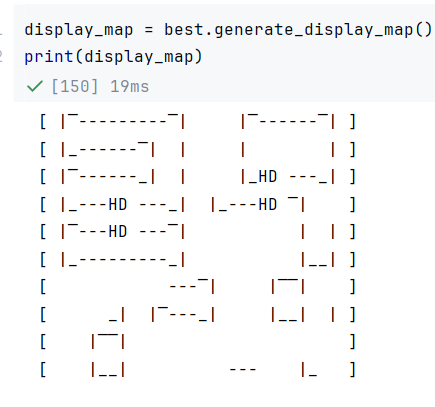

This is a flaw that is hard to resolve as it would add yet another layer of checking to ensure that if there is more than 1 door required, a room connection would need to be checked.

# Parameter Experimentation

Several experiments were conducted to investigate the impact of various parameters on the map generation process.

## Rate of Mutation for 1 valid door connected - Without fixed door positions.
Adjusting the mutation rate for wall segments connected to only one door revealed that a high rate (0.25) negatively impacted room formation.

Lower rates (0.025 and 0.0025) produced subtle changes, but their effects on the final map were difficult to isolate from the inherent randomness of the GA. While showing some potential, these minor improvements could be attributed to chance rather than a direct consequence of the altered mutation rate.

This difficulty in assessing the impact might be due to the culling of progressively growing walls. A change in a single-door wall segment might lead to its removal in later generations, hindering the observation of long-term effects.

The positioning of doors and the early stages of room creation appear to exert a stronger influence on the final map than the mutation of singly connected walls.

## Room size Changes, Width, Height and Number of doors  - Without fixed door positions.

The project's flexibility in generating maps of varying sizes and room counts is a significant advantage.

Experiments with different room sizes demonstrated that the algorithm functions correctly across various dimensions, but requires more generations to produce acceptable results for larger maps or higher room counts.

The feasible number of rooms is also constrained by the overall map size; even on a 10x10 map, generating four rooms proved challenging.

A smaller number of target rooms generally leads to better results, as there are fewer required connections. Increasing the two-door connection bonus further enhanced performance in these scenarios.

## Rate of Mutation for 1 valid door connected - With fixed door positions.
By fixing the door positions the rate of mutation for 1 door had a more obvious effect than the previous run without fixed doors.

The fixed door score without mutation (the control) was,
Best solution cost = '{best_solution.cost}' 1401

The first run with the highest rate of mutation (0.25)  yielded the following score,
Best solution cost = '{best_solution.cost}' 562

The run of the middle rate of mutation (0.025) yielded a score of
Best solution cost = '{best_solution.cost}' 1258

And finally the lowest rate of mutation (0.0025) for the 1 door walls yielded,
Best solution cost = '{best_solution.cost}' 1817


## Small Room size Changes, Width, Height and Number of doors  - With fixed door positions.

Fixing the door sizes was not conducted for large room sizes as it wouldn't make much of a difference since these were just an example of the flexibility of the project.

The run of the number of 2 rooms of the smaller fixed rooms ended with similar scores to both options, without any real rooms made, as such fixing the door position did not have much of an effect on a small map with one door.


## Observation on Parameters.

Parameter experimentation highlighted an important aspect of door generation, for the first iteration of these runs, each parameter set generates new door positions, introducing variability that makes controlled comparisons difficult.

The ability to fix door positions was then added to allow for a better comparison of the results obtained from these parameter experiments.

This yielded interesting results as the high rate of mutation of 1 door walls had a detrimental effect on the score, the middle weight had a slight reduction, but a low rate had a positive impact on the scoring.

Now these results are not conclusive since there is a variance with the starting populations, although it is a step towards a controlled experiment.

# Conclusion
This project demonstrates the potential of using genetic algorithms for procedural map generation in 2D pixel games.

While the generated maps aren't always perfect, the system effectively creates interconnected rooms separated by walls and doors, offering a degree of randomness and variability.

The project successfully addressed key challenges, such as defining valid room shapes, ensuring room connectivity, and designing effective genetic operators within a tile-based map representation.

The chosen approach of a tile index matrix, coupled with a sophisticated cost function that rewards valid room structures and connections, allows for the generation of diverse level layouts.

The development process highlighted the importance of balancing exploration and exploitation within the GA and the crucial role of visualization in debugging and refining the algorithm.

Despite the progress made, several areas could benefit from further development.

One key issue that remains is where a continuous valid wall is made that takes a lot of the map, this snaking wall prevents a lot of possible valid connections, the mutation rate for 1 door connected tiles aimed to alleviate this, however, it was not a full solution. The image below is a good representation of this problem.

![image](./images/small_room_snaked.png)

As well as this issue, the current room detection algorithm, while functional, could be improved to handle more complex room shapes and configurations, such as addressing the issue of room isolation when generating multiple rooms connected by a single door pair remains a key challenge for future work.

This could involve the use of other AI patterns to explore possible changes to the loose tail ends of the doors that have yet to be connected. Keeping track of the completed doors and isolated rooms (rooms where the walls connect back to the same door) would be needed for this approach.

By keeping track of the number of completed rooms, required isolated rooms and required tunnel or joining rooms would elevate this to a more complete function, however, due to the current complexity of the validation this will not be investigated.

Despite these limitations, the project provides a solid foundation for future research in procedural level generation using genetic algorithms.

---